In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import tempfile
from pathlib import Path
from io import StringIO
import copy

import numpy as np
import pandas as pd
import torch
import hydra
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns
from biopandas.pdb import PandasPdb
from colour import Color

from mutils.mutations import Mutation
from ppiformer.tasks.node import DDGPPIformer
from ppiformer.data.loader import get_dataloader
from ppiformer.definitions import PPIFORMER_WEIGHTS_DIR, PPIFORMER_ROOT_DIR, PPIFORMER_TEST_DATA_DIR
from mutils.definitions import MUTILS_DATA_DIR
from ppiref.definitions import PPIREF_DATA_DIR
from ppiformer.utils.api import predict_ddg
from ppiref.extraction import PPIExtractor
from ppiref.utils.ppi import PPIPath
from ppiformer.utils.torch import fill_diagonal
from ppiref.utils.residue import Residue

In [3]:
# Load weights
models = [
    DDGPPIformer.load_from_checkpoint(PPIFORMER_WEIGHTS_DIR / f'ddg_regression/{i}.ckpt', map_location=torch.device('cpu')).eval()
    for i in range(3)
]

/Users/anton/miniconda3/envs/ppiformer_u/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
/Users/anton/miniconda3/envs/ppiformer_u/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['classifier'])`.
  rank_zero_warn(


In [86]:
# pdb_path = '../../sak/data/Jan-Mican-6-Nov-2023/1bui-sak-wt.pdb'
# extractor.extract(pdb_path, partners=['A', 'B'])  # sak is A
pdb_path = Path('../../sak/data/Jan-Mican-6-Nov-2023/1bui-sak-wt-ternary-foranton.pdb')
pdb_path = PPIFORMER_TEST_DATA_DIR / '1bui_A_C.pdb'
partners = ['A', 'C']
# muts = ['MA12I']  # 'IA114T', 'MA12I,IA114T'
# muts = ['MC26I', 'MC26I', 'MC26I', 'MC26I']
# muts = ['SA2G,FA33G']
muts = ['SC16G,FC47G']

# Extract PPI into temp dir
ppi_dir_temo_obj = tempfile.TemporaryDirectory()
ppi_dir = Path(ppi_dir_temo_obj.name)
extractor = PPIExtractor(out_dir=ppi_dir, nest_out_dir=True, join=True, radius=10.0)
extractor.extract(pdb_path, partners=partners)  # sak is A
ppi_path = PPIPath.construct(ppi_dir, pdb_path.stem, partners)

# Predict
ddg, attn = predict_ddg(models, ppi_path, muts, return_attn=True)
ddg

Process 56308 preparing data: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


1 PPIs loaded: PPIInMemoryDataset(, n_muts=1)


tensor([1.0147])

In [87]:
attn.shape

torch.Size([3, 1, 1, 8, 2, 2, 124, 124])

In [88]:
ppi_df = PandasPdb().read_pdb(ppi_path).df['ATOM']
ppi_df = ppi_df.groupby(list(Residue._fields)).apply(lambda df: df[df['atom_name'] == 'CA'].iloc[0]).reset_index(drop=True)
ppi_df['id'] = ppi_df.apply(lambda row: ':'.join([row['residue_name'], row['chain_id'], str(row['residue_number']), row['insertion']]), axis=1)
ppi_df['id'] = ppi_df['id'].apply(lambda x: x[:-1] if x[-1] == ':' else x)
ppi_df

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx,id
0,ATOM,113,,CA,,VAL,,A,17,,...,15.563,63.592,1.0,21.54,,,C,NaN,12,VAL:A:17
1,ATOM,412,,CA,,ALA,,A,55,,...,11.059,60.161,1.0,17.41,,,C,NaN,19,ALA:A:55
2,ATOM,417,,CA,,ALA,,A,56,,...,12.940,60.013,1.0,21.85,,,C,NaN,24,ALA:A:56
3,ATOM,422,,CA,,HIS,,A,57,,...,16.228,61.288,1.0,17.33,,,C,NaN,29,HIS:A:57
4,ATOM,446,,CA,,GLU,,A,60,,...,17.674,64.472,1.0,42.18,,,C,NaN,39,GLU:A:60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,ATOM,4609,,CA,,ILE,,C,128,,...,22.516,39.827,1.0,13.59,,,C,NaN,961,ILE:C:128
120,ATOM,4617,,CA,,THR,,C,129,,...,21.289,38.305,1.0,31.72,,,C,NaN,969,THR:C:129
121,ATOM,4624,,CA,,LYS,,C,130,,...,19.216,39.226,1.0,22.87,,,C,NaN,976,LYS:C:130
122,ATOM,4647,,CA,,ILE,,C,133,,...,21.515,42.799,1.0,28.15,,,C,NaN,985,ILE:C:133


# Attention

In [89]:
attn.shape

torch.Size([3, 1, 1, 8, 2, 2, 124, 124])

In [90]:
attn[0, 0, 0, 0, 0, 0, 0, :].nansum()

tensor(1.)

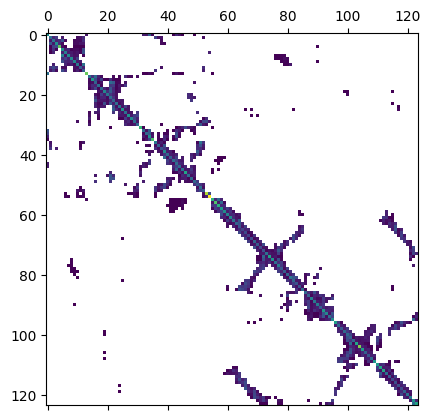

In [91]:
plt.matshow(attn[0, 0, 0, 0, 0, 0, :, :])

In [92]:
attn = torch.nan_to_num(attn, nan=1e-10)

In [93]:
# models, layers, heads, tokens, tokens
attn_sub = attn[:, 0, 0, :, 0, :, :, :]

In [94]:
ppi_df.iloc[5:15]

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx,id
5,ATOM,722,,CA,,LEU,,A,90,,...,9.933,58.764,1.0,25.39,,,C,NaN,48,LEU:A:90
6,ATOM,730,,CA,,GLU,,A,91,,...,9.687,55.002,1.0,18.71,,,C,NaN,56,GLU:A:91
7,ATOM,739,,CA,,PRO,,A,92,,...,11.148,53.596,1.0,23.90,,,C,NaN,65,PRO:A:92
8,ATOM,746,,CA,,THR,,A,93,,...,13.463,50.906,1.0,24.85,,,C,NaN,72,THR:A:93
9,ATOM,753,,CA,,ARG,,A,94,,...,15.149,53.569,1.0,18.08,,,C,NaN,79,ARG:A:94
10,ATOM,764,,CA,,LYS,,A,101,,...,13.562,52.663,1.0,18.87,,,C,NaN,90,LYS:A:101
11,ATOM,773,,CA,,ASP,,A,102,,...,13.507,55.718,1.0,20.91,,,C,NaN,99,ASP:A:102
12,ATOM,781,,CA,,ILE,,A,103,,...,9.871,56.674,1.0,18.63,,,C,NaN,107,ILE:A:103
13,ATOM,1095,,CA,,GLN,,A,145,,...,20.576,66.955,1.0,60.71,,,C,NaN,115,GLN:A:145
14,ATOM,1226,,CA,,ASN,,A,165,,...,13.482,42.977,1.0,15.80,,,C,NaN,124,ASN:A:165


In [95]:
muts_id = sum([Mutation(mut).wt_to_graphein() for mut in muts[0:1]], start=[])  # flatten ids of all sp muts 
ppi_df['mutated'] = ppi_df.apply(lambda row: row['id'] in muts_id, axis=1)

In [96]:
idx_mutated = torch.from_numpy(ppi_df.index[ppi_df['mutated']].to_numpy())
idx_mutated

tensor([56, 85])

In [97]:
row = ppi_df.iloc[5]
type(row['atom_number'])

numpy.int64

In [98]:
# Sum of direct attention from mutated residues

attn_sub = fill_diagonal(attn_sub.clone(), 1e-10)

attn_mutated = attn_sub[..., idx_mutated, :]
attn_mutated.shape
attns_per_token = torch.sum(attn_mutated, dim=(0, 1, 2, 3))
attns_per_token = (attns_per_token - attns_per_token.min()) / (attns_per_token.max() - attns_per_token.min())
attns_per_token += 1e-10
attns_per_token.shape

torch.Size([124])

In [99]:
attns_per_token

tensor([1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10,
        1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10,
        1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10,
        1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10,
        1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10,
        1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10,
        1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.5766e-01,
        5.6789e-02, 1.9773e-01, 9.1620e-02, 1.2060e-01, 1.6446e-01, 1.0000e-10,
        1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10,
        1.0000e-10, 6.7474e-01, 1.0000e-10, 1.0000e+00, 8.0265e-01, 1.8213e-01,
        4.5672e-02, 1.0000e-10, 1.0000e-10, 5.7440e-02, 5.2968e-01, 9.7951e-01,
        3.9018e-01, 4.7961e-01, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10,
        1.0000e-10, 1.0000e-10, 1.0000e-

In [100]:
ppi_df['attn'] = attns_per_token.numpy()
ppi_df

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx,id,mutated,attn
0,ATOM,113,,CA,,VAL,,A,17,,...,1.0,21.54,,,C,NaN,12,VAL:A:17,False,1.000000e-10
1,ATOM,412,,CA,,ALA,,A,55,,...,1.0,17.41,,,C,NaN,19,ALA:A:55,False,1.000000e-10
2,ATOM,417,,CA,,ALA,,A,56,,...,1.0,21.85,,,C,NaN,24,ALA:A:56,False,1.000000e-10
3,ATOM,422,,CA,,HIS,,A,57,,...,1.0,17.33,,,C,NaN,29,HIS:A:57,False,1.000000e-10
4,ATOM,446,,CA,,GLU,,A,60,,...,1.0,42.18,,,C,NaN,39,GLU:A:60,False,1.000000e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,ATOM,4609,,CA,,ILE,,C,128,,...,1.0,13.59,,,C,NaN,961,ILE:C:128,False,1.000000e-10
120,ATOM,4617,,CA,,THR,,C,129,,...,1.0,31.72,,,C,NaN,969,THR:C:129,False,1.000000e-10
121,ATOM,4624,,CA,,LYS,,C,130,,...,1.0,22.87,,,C,NaN,976,LYS:C:130,False,1.000000e-10
122,ATOM,4647,,CA,,ILE,,C,133,,...,1.0,28.15,,,C,NaN,985,ILE:C:133,False,1.000000e-10


# Py3DMol

In [101]:
!pip install py3Dmol

In [102]:
import py3Dmol


def read_mol(molpath):
    # https://huggingface.co/spaces/huhlim/cg2all/blob/main/app.py
    with open(molpath, "r") as fp:
        lines = fp.readlines()
    mol = ""
    for l in lines:
        mol += l
    #
    mol = mol.replace("OT1", "O  ")
    mol = mol.replace("OT2", "OXT")
    return mol

In [103]:
# Assign colors to chains
# TODO Sample for > 3 chains
chains = ppi_df['chain_id'].unique()
colors = [Color(c) for c in ['LimeGreen', 'HotPink', 'RoyalBlue']]
chain_to_color = dict(zip(chains, colors))
chain_to_color

# Init py3Dmol
ppi_py3dmol = read_mol(pdb_path)
view = py3Dmol.view(width=1000, height=1000)
view.addModelsAsFrames(ppi_py3dmol)
view.setStyle({'model': 0}, {'ray_opaque_background': 'off'}, {"stick": {'color': 'lightgrey', 'opacity': 0.5}})
view.setBackgroundColor('00cccccc')

# Sticks
# TODO Insertions
for i, row in ppi_df.iterrows():
    color = copy.deepcopy(chain_to_color[row['chain_id']])
    color.saturation = row['attn']
    color = color.hex_l
    if row['mutated']:
        view.addStyle({'chain': row['chain_id'], 'resi': str(row['residue_number'])}, {'stick': {'color': 'red', 'radius': 0.2, 'opacity': 1.0}})
    else:
        view.addStyle({'chain': row['chain_id'], 'resi': str(row['residue_number'])}, {'stick': {'color': color, 'radius': row['attn'] / 5, 'opacity': row['attn']}})

# Cartoon
for chain in chains:
    view.addStyle({'chain': chain}, {'cartoon': {'color': chain_to_color[chain].hex_l, 'opacity': 0.6}})

view.zoomTo()
view.write_html('py3dmol_tmp.html')
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Additional attention analysis

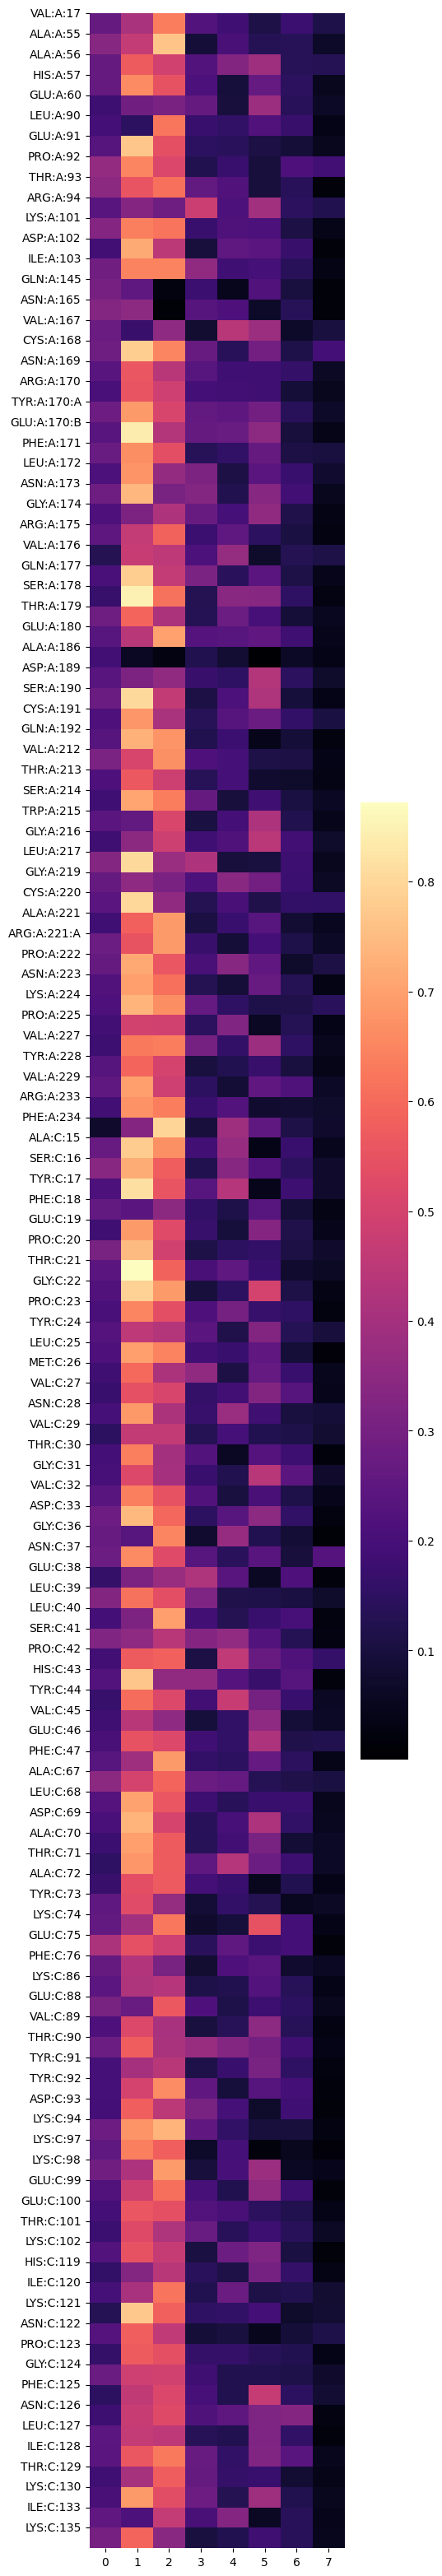

In [78]:
attn_per_layer = torch.amax(attn_sub, dim=(0, 2, 4))

plt.figure(figsize=(5, 40))
sns.heatmap(attn_per_layer.T, square=False, cmap='magma')
plt.yticks(list(range(len(ppi_df))), ppi_df['id'])
plt.show()

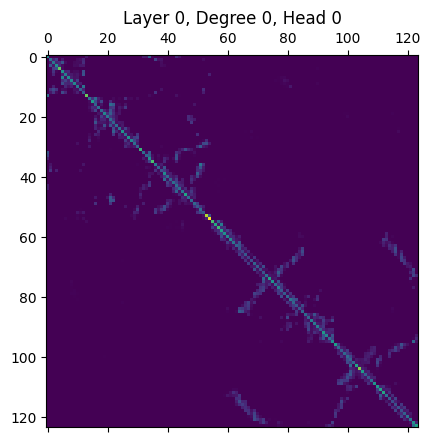

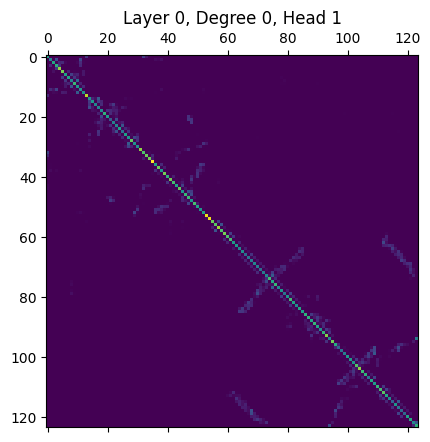

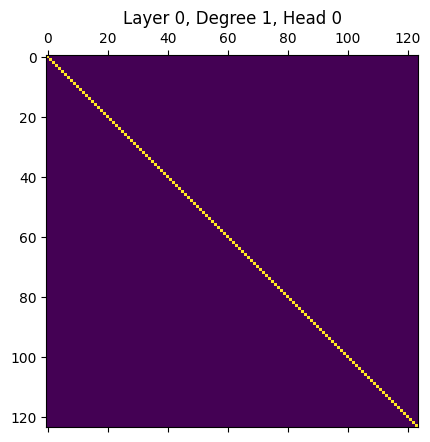

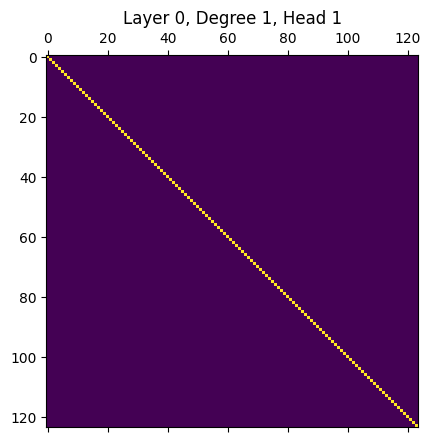

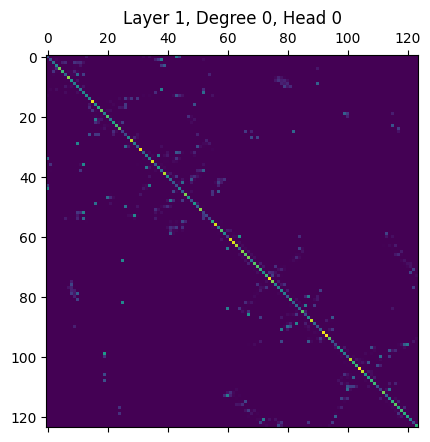

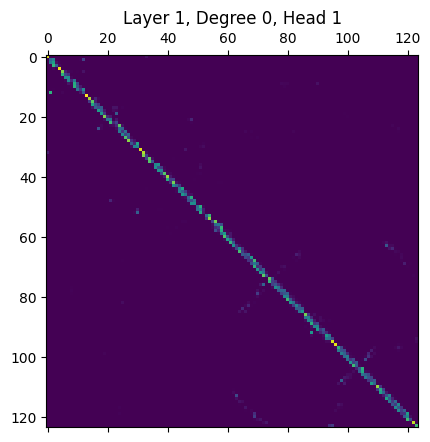

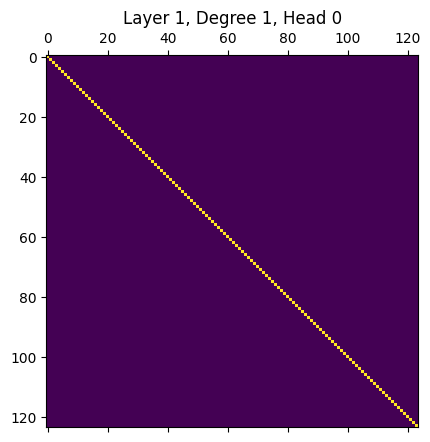

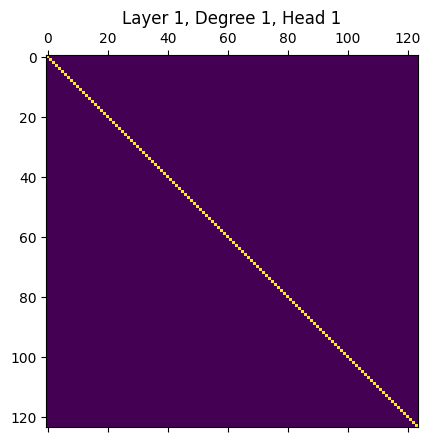

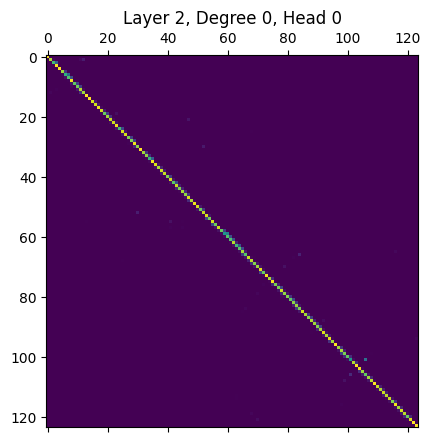

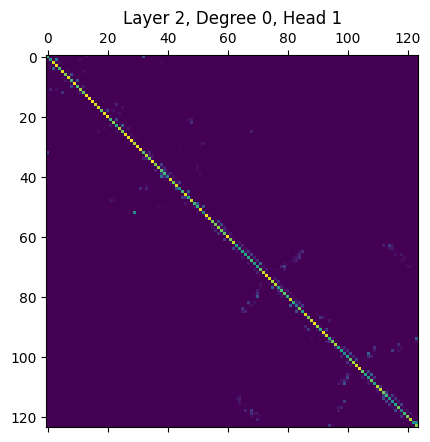

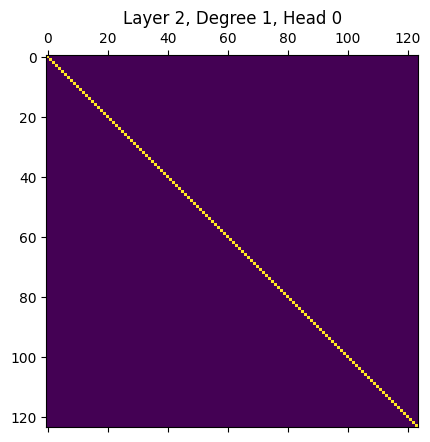

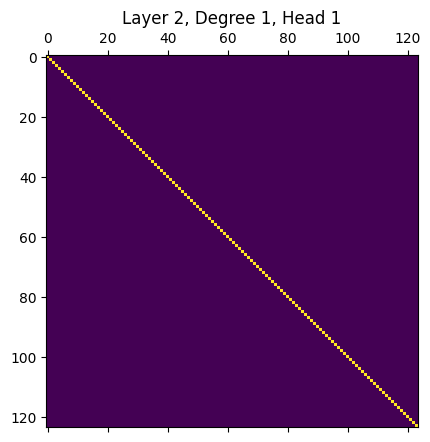

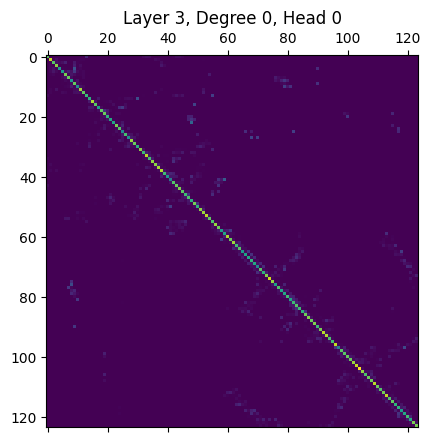

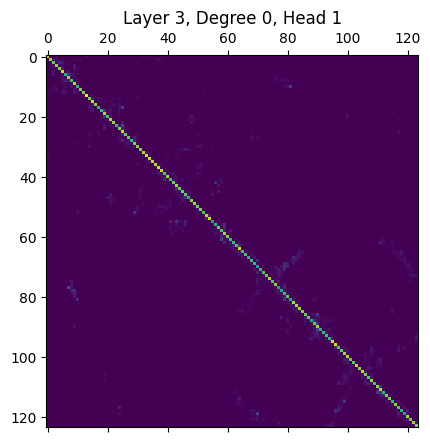

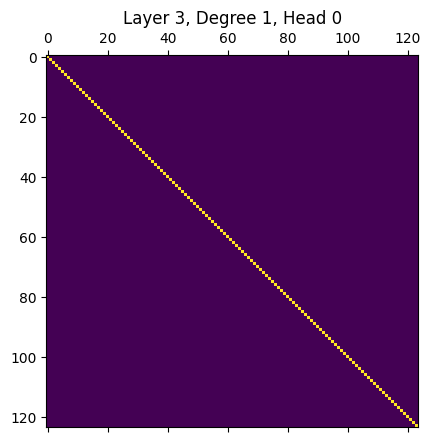

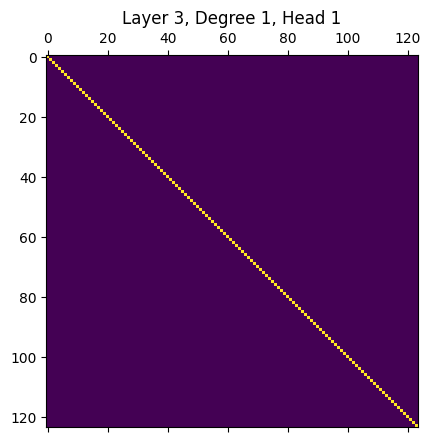

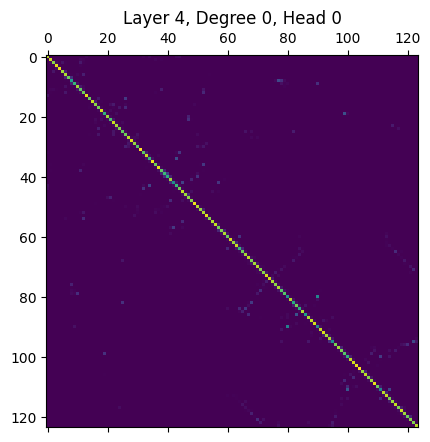

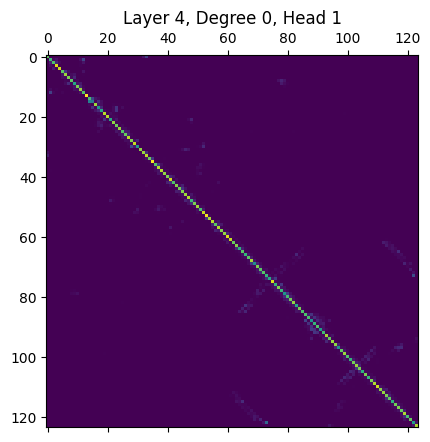

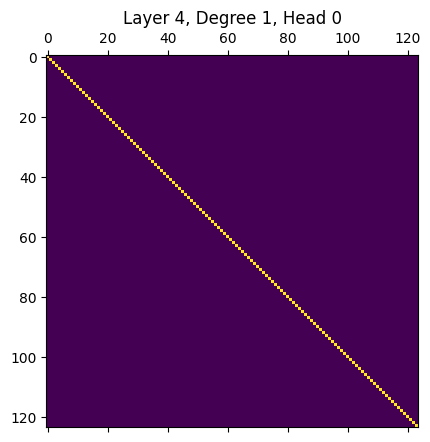

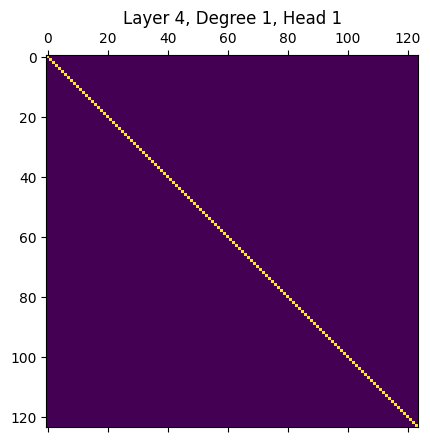

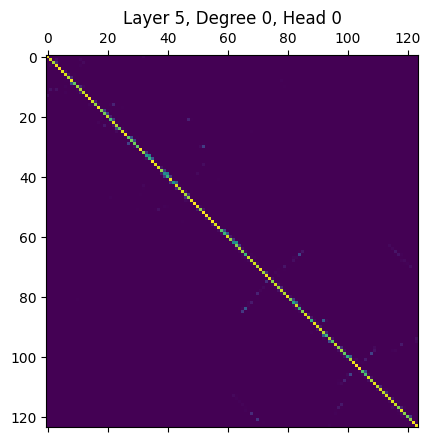

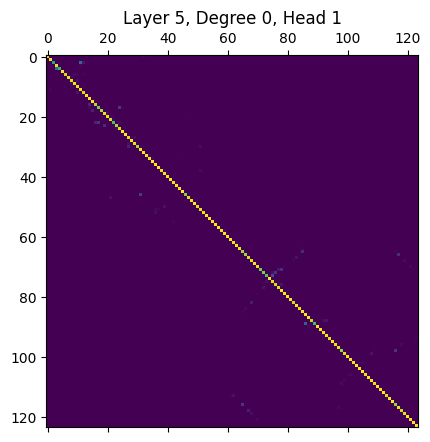

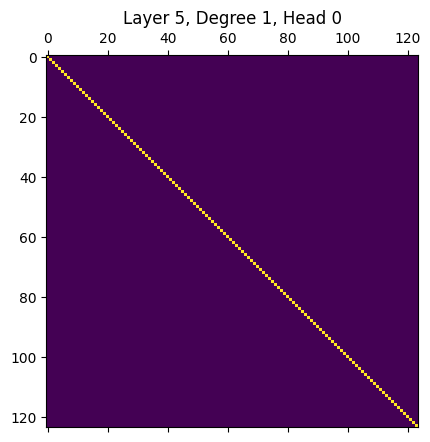

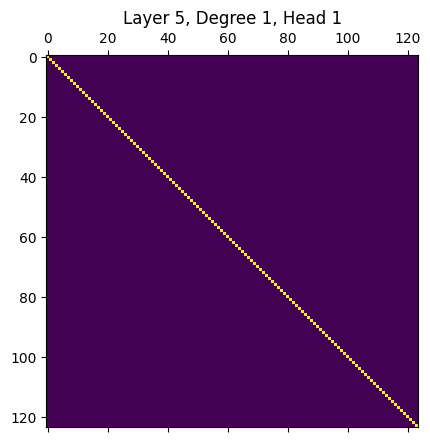

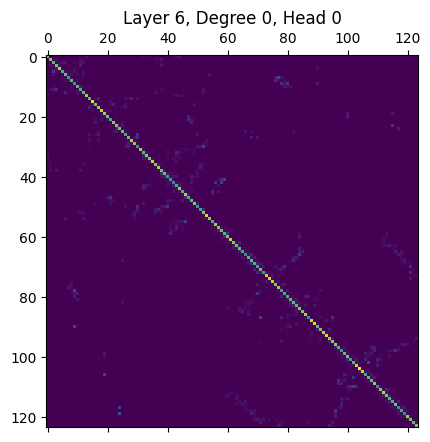

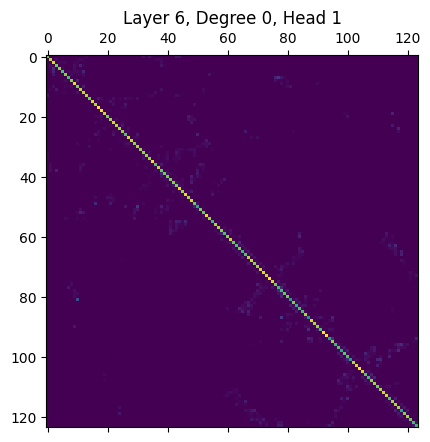

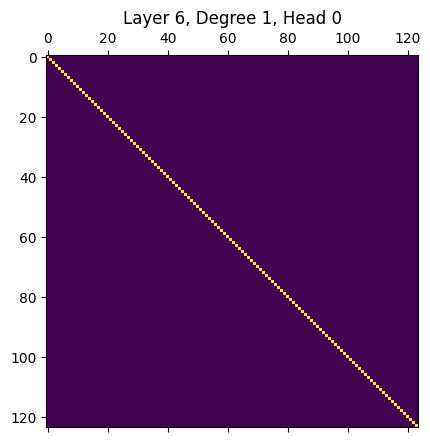

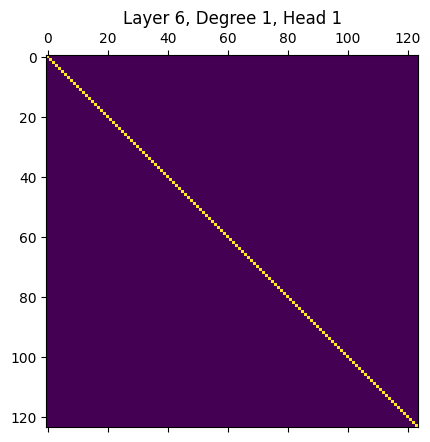

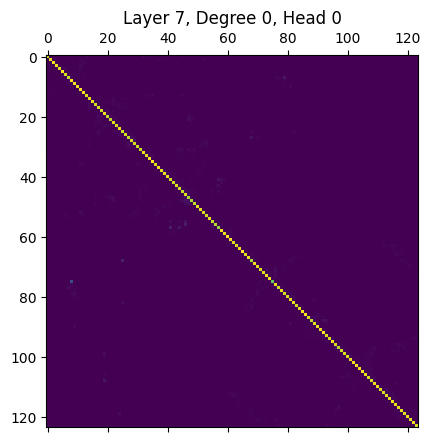

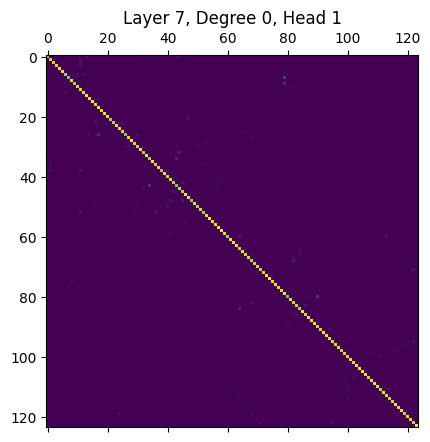

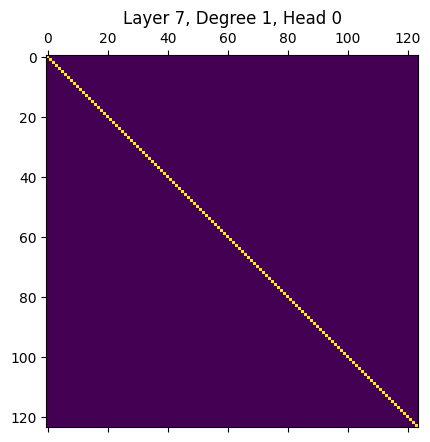

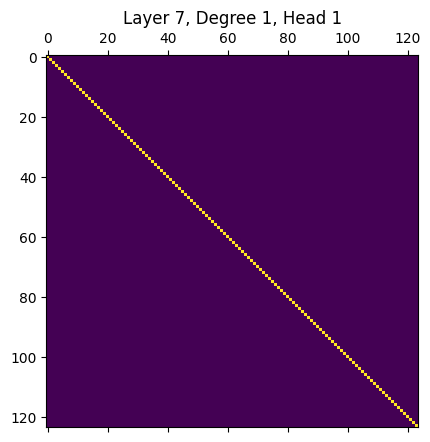

In [82]:
i_model = 0
i_mut = 0
i_batch = 0

for i_layer in range(attn.shape[3]):
    for i_degree in range(attn.shape[4]):
        for i_head in range(attn.shape[5]):
            plt.matshow(attn[i_model, i_mut, i_batch, i_layer, i_degree, i_head, :, :])
            plt.title(f'Layer {i_layer}, Degree {i_degree}, Head {i_head}')
            plt.show()